In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import joblib


In [2]:
# Load the data
data = pd.read_csv('card_transdata.csv')
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Exploratory Data Analysis

In [3]:
data.shape

(1000000, 8)

In [4]:
data.columns.tolist()

['distance_from_home',
 'distance_from_last_transaction',
 'ratio_to_median_purchase_price',
 'repeat_retailer',
 'used_chip',
 'used_pin_number',
 'online_order',
 'fraud']

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [6]:
data.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64


In [8]:
# Class Distribution
data['fraud'].value_counts()

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

In [9]:
data['fraud'].mean()

np.float64(0.087403)

Correlation Matrix

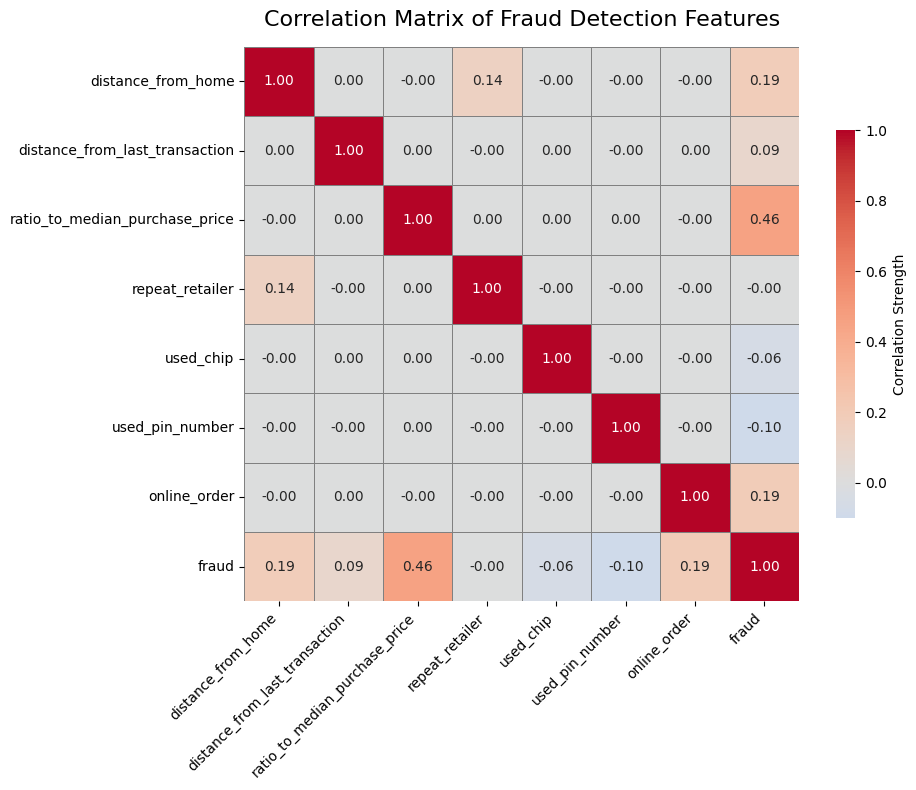

In [10]:
plt.figure(figsize=(10, 8))

correlation_matrix = data.corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={'shrink': 0.7, 'label': 'Correlation Strength'}
)

plt.title('Correlation Matrix of Fraud Detection Features', fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


Features and Target

In [11]:
# Prepare features and target
features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip','used_pin_number','online_order']

X = data[features]
y = data['fraud']

Handling Imbalanced Dataset Using SMOTE

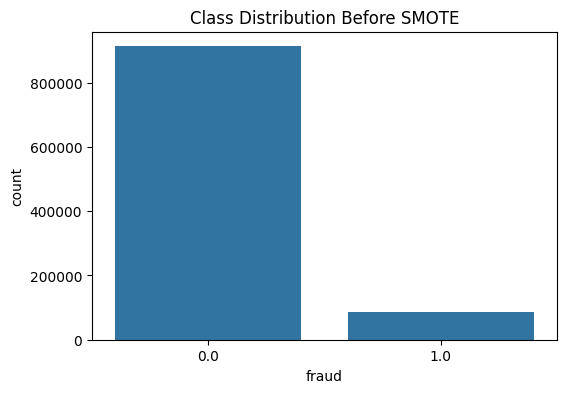

In [12]:
# 1. Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x="fraud", data=data)
plt.title("Class Distribution Before SMOTE")
plt.show()

In [13]:
smote = SMOTE(random_state=42)
x_resample, y_resample = smote.fit_resample(X,y)

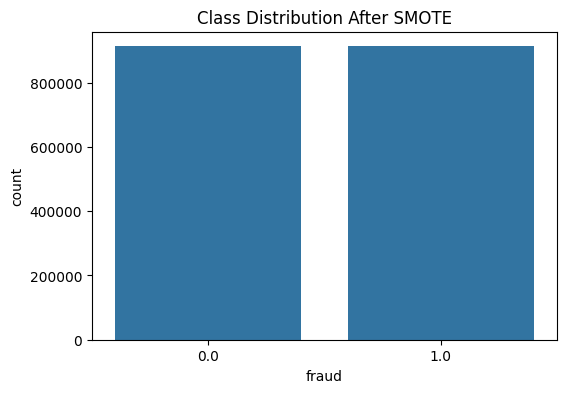

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.title("Class Distribution After SMOTE")
plt.show()

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size=0.2, random_state=42)

LightGBM Model Training

In [16]:
lgb_model = lgb.LGBMClassifier(
    boosting_type= 'gbdt',
    objective= 'binary',
    metrics= 'auc',
    is_unbalance = True,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=1,
    n_estimators=200
)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 729979, number of negative: 730176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1460155, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499933 -> initscore=-0.000270
[LightGBM] [Info] Start training from score -0.000270
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,1
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [17]:
y_pred = lgb_model.predict(X_test)


=== Model Evaluation ===
Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.95      0.97    182421
       Fraud       0.95      1.00      0.97    182618

    accuracy                           0.97    365039
   macro avg       0.97      0.97      0.97    365039
weighted avg       0.97      0.97      0.97    365039



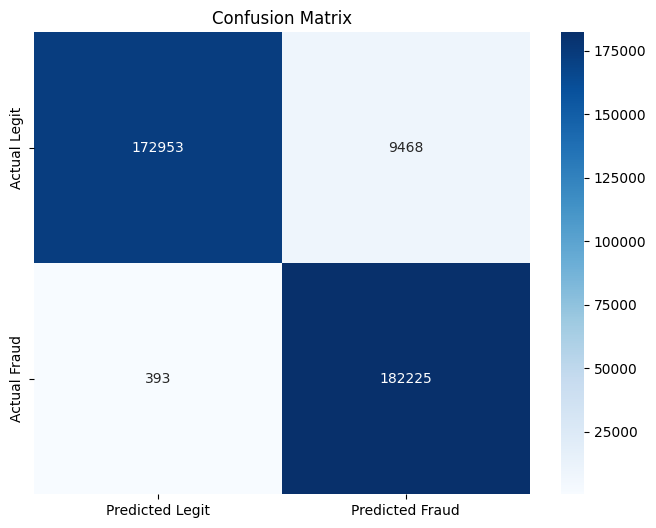

In [18]:
# Model Evaluation
print("\n=== Model Evaluation ===")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Predicted Legit', 'Predicted Fraud'],
           yticklabels=['Actual Legit', 'Actual Fraud'])
plt.title('Confusion Matrix')
plt.show()


In [19]:
# AUC Score
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.9730



=== Feature Importance ===


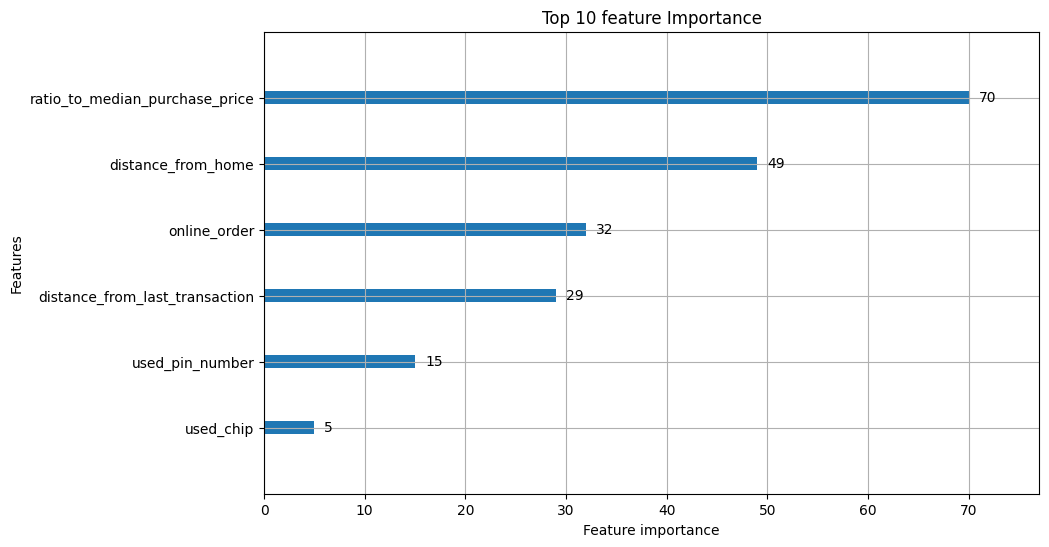

In [20]:
# Feature Importance
print("\n=== Feature Importance ===")
lgb.plot_importance(lgb_model, max_num_features=10, importance_type="split", figsize=(10,6))
plt.title("Top 10 feature Importance")
plt.show()

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, lgb_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

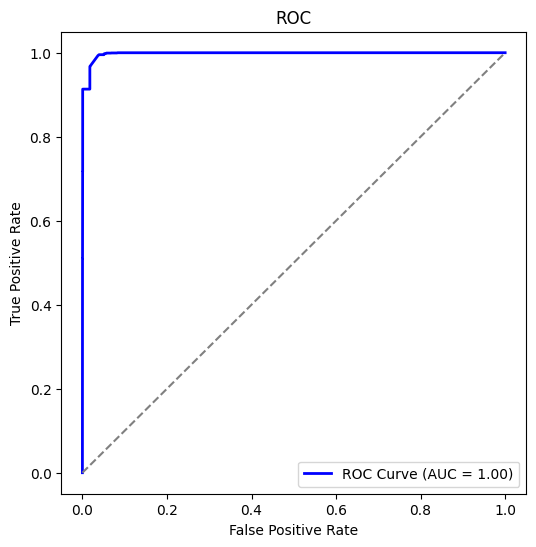

In [22]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [25]:
joblib.dump(lgb_model, "fraud_detection_model.jb")

['fraud_detection_model.jb']